In [1]:
import sys
sys.path.insert(0,'..')

from torchvision import utils
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time

from dataloader import *
from utils import *


In [3]:
class PretrainedEncoder(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.n_class = n_class
        
        # Encoder: Extracing encoder config from pretraiend model
        model_pretrained = torchvision.models.vgg11(pretrained=True)
        self.encoder = list(model_pretrained.children())[0] #type nn.Sequential
        
        # Encoder: Changing maxpool layer config to change return_indices to True
        for i, layer in enumerate(self.encoder):
            if type(layer) == torch.nn.modules.pooling.MaxPool2d:
                kernel_size, stride, padding, dilation, ceil_mode = layer.kernel_size, layer.stride, layer.padding, layer.dilation, layer.ceil_mode
                layer = torch.nn.modules.pooling.MaxPool2d(kernel_size, 
                                                           stride=stride, 
                                                           padding=padding, 
                                                           dilation=dilation, 
                                                           return_indices=True, 
                                                           ceil_mode=ceil_mode)
                self.encoder[i] = layer
                
        # Decoder: Defining decoder according to encoder
        self.decoder = nn.Sequential(
                    nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0), #20
                    nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1), #18
                    nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1), #16
                    nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0), #15
                    nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1), #13
                    nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1), #11
                    nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0), #10
                    nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1), #8
                    nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1), #6
                    nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0), #5
                    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1), #3
                    nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0), #2            
                    nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1), #1
            )
        
        self.classifier = nn.Conv2d(3,self.n_class, kernel_size=1)
        
    def forward(self, x):
        indices = []
        output_sizes = []
        # Encoder: Forward pass
        for i, layer in enumerate(self.encoder):
            # If layer is max pool, save the indices at which max occured and the size of the image before pooling
            if type(layer) == torch.nn.modules.pooling.MaxPool2d:
                size = x.shape[-2:]
                x, ind = layer(x)
                output_sizes.append(size)
                indices.append(ind)
            else:
                x = layer(x)
        
        # Decoder: Forward pass
        for i, layer in enumerate(self.decoder):
            if type(layer) == torch.nn.modules.pooling.MaxUnpool2d:
                ind = indices.pop()
                desired_size = output_sizes.pop()
                x = layer(x, ind, output_size = desired_size)
            else:
                x = layer(x)
        assert len(indices) == len(output_sizes) == 0, 'Imbalance in number of max pool and unpool 2d'
        
        # Classifier: Going from 3 to n_class channels
        x = self.classifier(x)
        
        return x
    
    def evaluate(self, img_batch, target_batch):
        # TODO: asserts and docstring
        target_batch = target_batch.argmax(dim=1)
        probs_batch = self.forward(img_batch)
        pred_batch = probs_batch.argmax(dim = 1)
        p_acc = pixel_acc(pred_batch, target_batch)
        iou_acc = iou(pred_batch, target_batch,self.n_class)     
        return p_acc, iou_acc

In [4]:
n_class = 34
model = PretrainedEncoder(n_class)
model = model.cuda()
for name, param in model.named_parameters():
    if 'encoder' in name:
        param.requires_grad = False

In [5]:
x = torch.rand(2,3,512,258).cuda()
out = model(x)
print('x.shape = ', x.shape)
print('out.shape = ', out.shape)

x.shape =  torch.Size([2, 3, 512, 258])
out.shape =  torch.Size([2, 34, 512, 258])


In [13]:
def test_fn(m):
    if isinstance(m, torch.nn.ConvTranspose2d):
        print(m)
        
model.apply(test_fn)

ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


PretrainedEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(5

In [15]:
transforms_composed = transforms.Compose([
                        transforms.Resize((512, 256)),
                        ])
train_dataset = CityScapesDataset(csv_file='../train.csv', transforms = transforms_composed)


In [34]:
out = train_dataset[206]

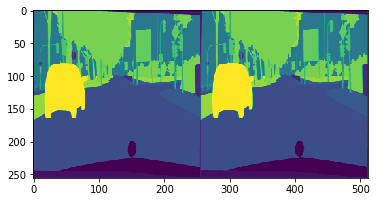

In [35]:
import matplotlib.pyplot as plt

plt.imshow(out[2].reshape(256, 512))

In [ ]:
# model_pretrained = torchvision.models.vgg11(pretrained=True)
# # print(model_pretrained)
# encoder = list(model_pretrained.children())[0]
# print(encoder)
# # encoder[12] = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)
# print(encoder[2].return_indices)

In [ ]:
# # encoder_mod = deepcopy(encoder)
# for i, layer in enumerate(encoder):
#     if type(layer) == torch.nn.modules.pooling.MaxPool2d:
#         kernel_size, stride, padding, dilation, ceil_mode = layer.kernel_size, layer.stride, layer.padding, layer.dilation, layer.ceil_mode
#         layer = torch.nn.modules.pooling.MaxPool2d(kernel_size, 
#                                                    stride=stride, 
#                                                    padding=padding, 
#                                                    dilation=dilation, 
#                                                    return_indices=True, 
#                                                    ceil_mode=ceil_mode)
#         encoder[i] = layer

In [ ]:
# encoder_small = encoder[0:3]
# decoder_small = nn.Sequential(
#         nn.MaxUnpool2d(kernel_size=3, stride=2, padding=0),
#         nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
#         )
# test_image = torch.rand(2, 3, 512, 256)
# out_encoder = encoder_small(test_image)

# x = test_image
# indices = []
# output_sizes = []
# print(x.shape)
# for i, layer in enumerate(encoder_small):
#     if type(layer) == torch.nn.modules.pooling.MaxPool2d:
#         size = x.shape[-2:]
#         output_sizes.append(size)
#         x, ind = layer(x)
#         indices.append(ind)
#     else:
#         x = layer(x)

# print(x.shape)

# for i, layer in enumerate(decoder_small):
#     if type(layer) == torch.nn.modules.pooling.MaxUnpool2d:
#         ind = indices.pop()
#         desired_size = output_sizes.pop()
#         x = layer(x, ind, output_size = desired_size)
#     else:
#         x = layer(x)
        
# print(x.shape)